# California MMP Rollout Analysis

*Author: Nicole Lin*

**Purpose**
1. summary stats of MMP rollout 
2. investigate variations in enforcement across regions and facility types

**Key Questions**
1. Is the data good? 
    - Any missing data?
    - Does that make analysis reliable?
2. If the data is good, then:
    - Are there regional variations in 
        - Enforcement rates? 
            - for all violations
            - for effluent violations
            - for MMP violations
        - Time between violations and enforecements? 
            - for all violations 
            - for effluent violations
            - for MMP violations
        - Compliance rates?
            - Proportion of permits with MMP violations over time
            - Proportion of permits in ESNC over time

**Data**

Using data Erin Mustain provided in an email sent on June 17th, 2020 at 3:03 PM; Subject Line "RE: Invitation: Stanford RegLab | State Water Resources Control Board @ Tue Jun 16, 2020 12pm - 1pm (PDT) 

Data files location: In Sherlock: `$OAK/EPA/Data/manual/california`

In [1]:
import os

import pandas as pd
import numpy as np 
from datetime import datetime as dt
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)

In [2]:
oak_dir = '/Users/hongjinl/sherlock_oak'
data_dir = os.path.join(oak_dir, 'EPA', 'Data', 'manual', 'california')

# facility table
facilities = pd.read_csv(os.path.join(data_dir, 'ca_facilities_20210922.csv'), encoding='latin1', engine='python')
npdes = pd.read_csv(os.path.join(data_dir, 'ca_npdes_facilities_20210922.csv'), encoding='latin1', engine='python')
facility_counts = pd.read_csv(os.path.join(data_dir, 'ca_facility_count_20210922.csv'), encoding='latin1', engine='python')
# enforcement table
enforcements = pd.read_csv(os.path.join(data_dir, 'wastewater-enforcement-actions.csv'), encoding='latin1')
# violations table including all violations
violations = pd.read_csv(os.path.join(data_dir, 'water-board-wastewater-violations-2001-2016.csv'), encoding='latin1')
# effluent violations first exported by Erin with MMP label
## filtered to NPDES permits after 2006
eff_violations = pd.read_excel(os.path.join(data_dir, 'violations_export.xlsx'), encoding='latin1')
# cross reference table to join violations and enforcements
xref = pd.read_csv(os.path.join(data_dir, 'wastewater-violations-linked-to-enforcement-actions-2005-2016.csv'), encoding='latin1')

In [128]:
# 0 conversion errors
npdes['Termination Date'] = pd.to_datetime(npdes['Termination Date'], errors = 'coerce')
# 216 out of 0.5% results in conversion errors
enforcements['EFFECTIVE DATE'] = pd.to_datetime(enforcements['EFFECTIVE DATE'], errors = 'coerce')
# 0 conversion errors
violations['OCCURRED ON'] = pd.to_datetime(violations['OCCURRED ON'], errors = 'coerce')
# 0 conversion errors
xref['DATE_ADDED_TO_ENFORCEMENT'] = pd.to_datetime(xref['DATE_ADDED_TO_ENFORCEMENT'], errors = 'coerce')

In [135]:
print(f'facilities: {len(facilities)}')
print(f'npdes facilities: {len(npdes)}')
print(f'enforcements: {len(enforcements)}')
print(f'violations: {len(violations)}')
print(f'filtered effluent violations: {len(eff_violations)}')
print(f'cross reference: {len(xref)}')

facilities: 189060
npdes facilities: 7008
enforcements: 44585
violations: 322974
filtered effluent violations: 42304
cross reference: 241393


In [5]:
# define utility functions

def plot_hist(df, col):
    plt.title(col)
    plt.hist(df[col].fillna('missing'), bins = len(df[col].unique()))
    plt.xticks(rotation = 90)
    plt.show()

In [345]:
regions = violations['VIOLATED FACILITY REGION'].unique().tolist()[1:] # exclude nan value
regions.sort()
# 4 and 5S accounts for most of the MMP violations and 9 has consistently implemented the statue from the beginning
sub_regions = ['4','5S', '9']

r_2000 = ['9']
r_2008 = ['2', '3', '4', '5F', '5R', '5S']
r_2013 = ['1', '7']
r_backlog = ['8']

Regions (map: https://www.waterboards.ca.gov/waterboards_map.html): 
- 1: North Coast Region
- 2: San Francisco Bay region
- 3: Central Coast Region
- 4: Los Angeles Region
- 5: Central Valley Region 
    - 5F: Fresno Branch
    - 5R: Redding Branch
    - 5S: Sacramento Branch 
- 6: Lahontan Region
- 7: Colorado River Basin Region
- 8: Santa Ana Region
- 9: San Diego Region

==> Most MMP violations are from region 4 and 5S

## 0. Basic Summary Statistics

- ANIMALWASTE: confined animal facilities
- CER: 401 Certification. Clean Water Act Section 401 Certification; regulation of dredge and fill projects.
- DOD: Department of Defense. To address the cleanup of federal facilities where releases of pollutants have occurred
- FORESTRY: addresses nonpoint source (NPS) discharges associated with the use of our forested landscapes.  Forest use activities with the potential to discharge sediment and remove stream shading primarily include: timber harvesting, fuels management, vegetation management, salvage logging and post-fire impacts, road construction, livestock grazing, and recreational use. 
- IRRI: Irrigated Lands: This program regulates discharges from irrigated agricultural lands, from both irrigation flows and stormwater runoff.
- LNDISP: Land Disposal: The Land Disposal program regulates solid waste discharge to land for treatment, storage and disposal in waste management units. Waste management units include waste piles, surface impoundments, and landfills.
- NPDES: National Pollutant Discharge Elimination System: This is a federal program that regulates discharges of wastewater to waters of the United States.
- PLANNING
- SSO: A sanitary sewer overflow (SSO) is any overflow, spill, release, discharge or diversion of untreated or partially treated wastewater from a sanitary sewer system. SSOs often contain high levels of suspended solids, pathogenic organisms, toxic pollutants, nutrients, oil, and grease.
- Storm Water: Storm water is defined by US EPA as the runoff generated when precipitation from rain and snowmelt events flows over land or impervious surfaces without percolating into the ground. Storm water is often considered a nuisance because it mobilizes pollutants such as motor oil and trash. In most cases, storm water flows directly to water bodies through sewer systems, contributing a major source of pollution to rivers, lakes, and the ocean. Storm water discharges in California are regulated through National Pollutant Discharge Elimination System (NPDES) permits.
- TANKS: underground storage tanks
- UNREGS: A non regulated site that is or was of interest.
- WDR: Waste discharges that can be exempted from the California Code of Regulations (CCR) requirements are issued waste discharge requirements (WDRs) and are regulated by the WDR Program. Typical discharge types includes domestic or municipal wastewater, food processing related wastewater, and industrial wastewater.

In [304]:
facility_counts

,Region,ANIMALWASTE,CER,DOD,FORESTRY,IRRI,LNDISP,MONITORING,NPDES,PLANNING,SSO,Storm Water,TANKS,UNREGS,WDR,Total
0,1,150,2124,2,3120,4353,63,0,148,1,73,3498,104,3,615,14053
1,2,70,2380,11,0,292,105,0,1012,0,146,17544,3,24,193,21725
2,3,14,972,7,147,1491,85,0,351,0,116,6448,30,1,1130,10748
3,4,4,741,11,0,2,216,1,2209,0,151,23806,0,0,1398,28400
4,5F,893,636,0,96,20,232,0,204,0,172,9657,4,0,1086,12944
5,5R,47,1732,0,1506,1565,57,1,278,0,60,3060,16,5,390,8632
6,5S,1131,2129,10,352,553,178,0,759,0,217,21074,23,0,1132,27453
7,6T,13,684,0,237,323,19,0,77,0,23,1191,0,3,346,2869
8,6V,12,562,0,3,0,117,0,54,0,52,4262,0,2,184,5236
9,7,34,400,2,0,4,109,0,107,0,35,3565,0,0,463,4708


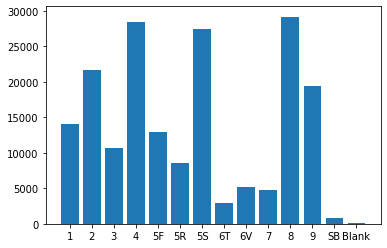

In [305]:
plot_df = facility_counts[facility_counts['Region'] != 'TOTAL']
plt.bar(plot_df.Region, plot_df.Total)
plt.show()

[]

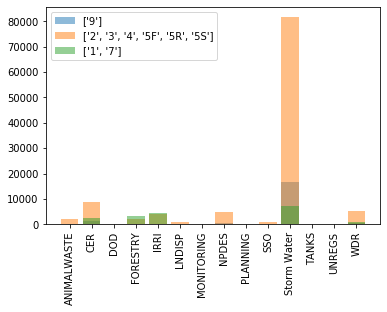

In [351]:
plot_df = facility_counts.melt(id_vars = ['Region'],
                               var_name = 'Program',
                               value_name = 'Count')
plot_df = plot_df[plot_df['Program'] != 'Total']

rs = [r_2000, r_2008, r_2013]
for r in rs: 
    region_df = plot_df[plot_df.Region.isin(r)]
    df = region_df.groupby(['Program'])['Count'].sum().to_frame().reset_index()
    plt.bar(df.Program, df.Count, alpha = 0.5)
plt.legend(rs)
plt.xticks(rotation = 90)
plt.plot()

In [366]:
dfs = []
for r in rs:    
    region_df = plot_df[plot_df.Region.isin(r)]
    df = region_df.groupby(['Program'])['Count'].sum().to_frame().reset_index()
    df.columns = ['Program', '_'.join(map(str, r))]
    dfs.append(df)
counts = pd.merge(dfs[0], dfs[1], how = 'outer')
counts = pd.merge(counts, dfs[2], how = 'outer')
counts[counts['Program'].isin(['ANIMALWASTE', 'NPDES', 'Storm Water', 'WDR'])]

,Program,9,2_3_4_5F_5R_5S,1_7
0,ANIMALWASTE,25,2159,184
7,NPDES,528,4813,255
10,Storm Water,16820,81589,7063
13,WDR,401,5329,1078


## 1. Data Quality

### Date Range

/Users/hongjinl/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/hongjinl/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


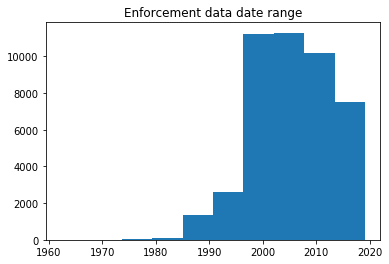

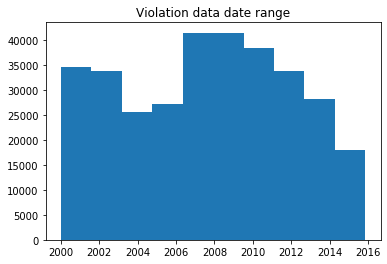

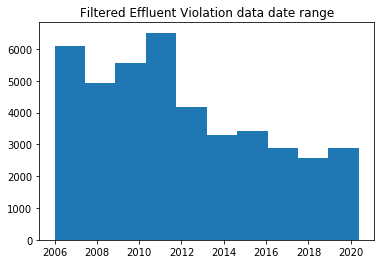

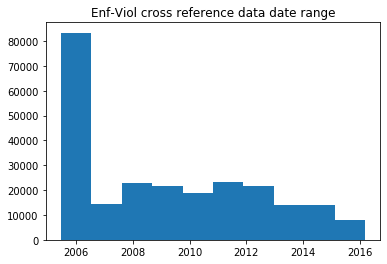

In [307]:
plt.title('Enforcement data date range')
plt.hist(enforcements['EFFECTIVE DATE'])
plt.show()

plt.title('Violation data date range')
plt.hist(violations['OCCURRED ON'])
plt.show()

plt.title('Filtered Effluent Violation data date range')
plt.hist(eff_violations['OCCURRED ON'])
plt.show()

plt.title('Enf-Viol cross reference data date range')
plt.hist(xref['DATE_ADDED_TO_ENFORCEMENT'])
plt.show()

In [308]:
enforcements['enforcement_year'] = [t.year for t in enforcements['EFFECTIVE DATE']]
violations['violation_year'] = [t.year for t in violations['OCCURRED ON']]
eff_violations['eff_violation_year'] = [t.year for t in eff_violations['OCCURRED ON']]
xref['xref_year'] = [t.year for t in xref['DATE_ADDED_TO_ENFORCEMENT']]

In [309]:
np.sort(enforcements.enforcement_year.unique())

array([1962., 1963., 1964., 1965., 1966., 1971., 1972., 1973., 1974.,
       1975., 1976., 1977., 1978., 1979., 1980., 1981., 1982., 1983.,
       1984., 1985., 1986., 1987., 1988., 1989., 1990., 1991., 1992.,
       1993., 1994., 1995., 1996., 1997., 1998., 1999., 2000., 2001.,
       2002., 2003., 2004., 2005., 2006., 2007., 2008., 2009., 2010.,
       2011., 2012., 2013., 2014., 2015., 2016., 2017., 2018., 2019.,
         nan])

In [310]:
np.sort(violations.violation_year.unique())

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015])

In [311]:
np.sort(eff_violations.eff_violation_year.unique())

array([2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2020])

In [312]:
np.sort(xref.xref_year.unique())

array([2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016])

==> we can only match violations and enforcements records from 2005 and 2015.

### Match enforcement and violation records (2005 - 2015)

In [313]:
enforcements.columns

Index(['REGION', 'FACILITY ID', 'FACILITY NAME', 'AGENCY NAME', 'PLACE TYPE',
       'PLACE SUBTYPE', 'PLACE LATITUDE', 'PLACE LONGITUDE', 'WDID',
       'REG MEASURE ID', 'REG MEASURE TYPE', 'ENFORCEMENT_ACTION_ID',
       'ORDER / RESOLUTION NUMBER', 'ENFORCEMENT ACTION TYPE',
       'EFFECTIVE DATE', 'ADOPTION / ISSUANCE DATE', 'TERMINATION DATE',
       'ACL ISSUANCE DATE', 'EPL ISSUANCE DATE', 'STATUS', 'TITLE',
       'DESCRIPTION', 'PROGRAM', 'PROGRAM CATEGORY', 'TOTAL ASSESSMENT AMOUNT',
       'INITIAL ASSESSED AMOUNT', 'LIABILITY $ AMOUNT', 'PROJECT $ AMOUNT',
       'LIABILITY $ PAID', 'PROJECT $ COMPLETED',
       'TOTAL $ PAID/COMPLETED AMOUNT', 'Location 1', 'enforcement_year'],
      dtype='object')

In [314]:
violations.columns

Index(['VIOLATED FACILITY REGION', 'FACILITY_ID', 'FACILITY NAME',
       'AGENCY NAME', 'PLACE TYPE', 'PLACE SUBTYPE', 'PLACE LATITUDE',
       'PLACE LONGITUDE', 'WDID', 'REG MEASURE ID', 'REG MEAS TYPE',
       'VIOLATION_ID', 'VIOLATION TYPE', 'VIOLATION SUBTYPE',
       'VIOLATION DESCRIPTION', 'STATUS', 'OCCURRED ON', 'PROGRAM',
       'PROGRAM CATEGORY', 'Parameter', 'Limit', 'Result', 'Units', 'Period',
       'Monitoring Location', 'Location 1', 'violation_year'],
      dtype='object')

In [315]:
xref.columns

Index(['VIOLATION_ID', 'ENFORCEMENT_ACTION_ID', 'DATE_ADDED_TO_ENFORCEMENT',
       'xref_year'],
      dtype='object')

In [316]:
enforcements = enforcements.rename(columns = {'ENFORCEMENT ID (EID)':'ENFORCEMENT_ACTION_ID'})
violations = violations.rename(columns = {'VIOLATION ID (VID)':'VIOLATION_ID'})
eff_violations = eff_violations.rename(columns = {'VIOLATION ID (VID)':'VIOLATION_ID'})

start_year = 2006
end_year = 2015
enforcements_trim = enforcements[(enforcements.enforcement_year >= start_year)]
violations_trim = violations[(violations.violation_year >= start_year) & (violations.violation_year <= end_year)]
eff_violations_trim = eff_violations[(eff_violations.eff_violation_year >= start_year) & (eff_violations.eff_violation_year <= end_year)]
xref_trim = xref[(xref.xref_year >= start_year) & (xref.xref_year <= end_year)]

In [317]:
# match violation ids with cross reference table 
viol_out = pd.merge(violations_trim, xref_trim, on = 'VIOLATION_ID', how = 'outer')
viol_in = pd.merge(violations_trim, xref_trim, on = 'VIOLATION_ID', how = 'inner')
print(f"# matched records: {len(viol_in)}")      
print(f"In the violations table, {sum(viol_out.ENFORCEMENT_ACTION_ID.isna())} ({sum(viol_out.ENFORCEMENT_ACTION_ID.isna())/len(violations_trim)*100}%) records dont have enforcement records matched in the xref table.")
print(f"In the xref table, {sum(viol_out['VIOLATION TYPE'].isna())} ({sum(viol_out['VIOLATION TYPE'].isna())/len(xref_trim)*100}%) recores dont have violation records matched.")

# matched records: 120436
In the violations table, 114517 (54.49090684151924%) records dont have enforcement records matched in the xref table.
In the xref table, 40871 (25.337400112828334%) recores dont have violation records matched.


==> There are quite a lot of enforcement actions that cannot be matched to violation records.

In [318]:
# match enforcement ids with cross reference table 
enf_out = pd.merge(enforcements_trim, xref_trim, on = 'ENFORCEMENT_ACTION_ID', how = 'outer')
enf_in = pd.merge(enforcements_trim, xref_trim, on = 'ENFORCEMENT_ACTION_ID', how = 'inner')
print(f"# matched records: {len(enf_in)}")     
print(f"In the enforcements table, {sum(enf_out.VIOLATION_ID.isna())} ({sum(enf_out.VIOLATION_ID.isna())/len(enforcements_trim)*100}%) records dont have violation records matched in the xref table.")
print(f"In the xref table, {sum(enf_out['ENFORCEMENT ACTION TYPE'].isna())} ({sum(enf_out['ENFORCEMENT ACTION TYPE'].isna())/len(xref_trim)*100}%) records dont have enforcement records matched.")

# matched records: 135836
In the enforcements table, 5878 (29.43857364651675%) records dont have violation records matched in the xref table.
In the xref table, 25471 (15.790387273955872%) records dont have enforcement records matched.


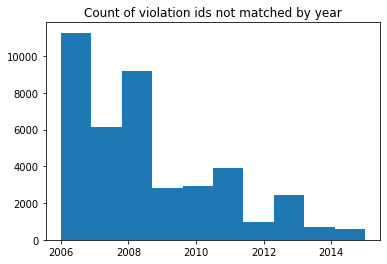

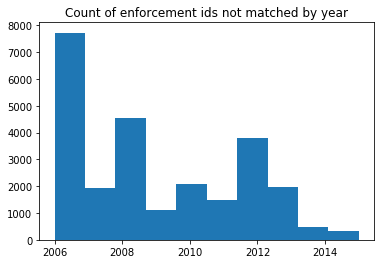

In [319]:
# what are the records that are missing? 
## xref violation id 
plt.title('Count of violation ids not matched by year')
plt.hist(viol_out[viol_out['VIOLATION TYPE'].isna()]['xref_year'])
plt.show()

plt.title('Count of enforcement ids not matched by year')
plt.hist(enf_out[enf_out['ENFORCEMENT ACTION TYPE'].isna()]['xref_year'])
plt.show()

==> Most missing records are from 2005. This might be a result of data system transfer in 2005.

In [320]:
df = enf_out[enf_out['ENFORCEMENT ACTION TYPE'].isna()]
df_2005 = df[df['xref_year'] == 2005]
print(f"{len(df_2005)/len(df)*100}% missing enforcement records are from 2005.")

df = viol_out[viol_out['VIOLATION TYPE'].isna()]
df_2005 = df[df['xref_year'] == 2005]
print(f"{len(df_2005)/len(df)*100}% missing violation records are from 2005.")

0.0% missing enforcement records are from 2005.
0.0% missing violation records are from 2005.


In [321]:
merged_out = pd.merge(viol_out, enforcements_trim, on = 'ENFORCEMENT_ACTION_ID', how = 'outer')
merged_trim = merged_out[~merged_out['VIOLATION TYPE'].isna()]
print(f"{len(merged_trim)/len(merged_out)*100}% violation records retained.")

83.40480365776601% violation records retained.


In [322]:
print(f"{sum(merged_trim['WDID_x'].isna())/len(merged_trim)*100}% of violation records are missing facility ids. We will remove them from the data.")
merged_trim = merged_trim[~merged_trim['WDID_x'].isna()]

3.7126574251020417% of violation records are missing facility ids. We will remove them from the data.


In [323]:
# joining facility info

## remove facilities with missing ID 
print(f"{sum(facilities.WDID.isna())/len(facilities)*100}% of facility records are missing facility ID. We will remove them from the data.")
facilities = facilities[~facilities.WDID.isna()]

df = facilities.groupby(['WDID'])['Agency'].count().to_frame().reset_index()
df.columns = ['WDID', 'record_count']
df['duplicate_flag'] = df.record_count > 1
print(f"{sum(df.duplicate_flag)/len(df)*100}% facility have duplicate facility ids. We will remove them from the facility data.")
df1 = pd.merge(facilities, df, how = 'left')
facilities = df1[~df1.duplicate_flag]

0.0% of facility records are missing facility ID. We will remove them from the data.
0.0016844563978461419% facility have duplicate facility ids. We will remove them from the facility data.


In [324]:
# add npdes flag
npdes['npdes_flag'] = True
facilities = pd.merge(facilities, npdes[['WDID', 'npdes_flag']], how = 'left')
facilities.npdes_flag = facilities.npdes_flag.fillna(False)

In [325]:
df = pd.merge(merged_trim, facilities, how = 'left', left_on = 'WDID_x', right_on = 'WDID')
df1 = df[['WDID_x', 'WDID']].drop_duplicates(['WDID_x'])
print(f"{sum(df1.WDID.isna())/len(df1)*100}% of violators do not have records in the facility table. We will keep them for now.")
merged_trim = df

19.031561909900187% of violators do not have records in the facility table. We will keep them for now.


In [326]:
merged_trim['npdes_flag'] = merged_trim['npdes_flag'].fillna(False)
merged_trim.head()

,VIOLATED FACILITY REGION,FACILITY_ID,FACILITY NAME_x,AGENCY NAME_x,PLACE TYPE_x,PLACE SUBTYPE_x,PLACE LATITUDE_x,PLACE LONGITUDE_x,WDID_x,REG MEASURE ID_x,REG MEAS TYPE,VIOLATION_ID,VIOLATION TYPE,VIOLATION SUBTYPE,VIOLATION DESCRIPTION,STATUS_x,OCCURRED ON,PROGRAM_x,PROGRAM CATEGORY_x,Parameter,Limit,Result,Units,Period,Monitoring Location,Location 1_x,violation_year,ENFORCEMENT_ACTION_ID,DATE_ADDED_TO_ENFORCEMENT,xref_year,REGION,FACILITY ID,FACILITY NAME_y,AGENCY NAME_y,PLACE TYPE_y,PLACE SUBTYPE_y,PLACE LATITUDE_y,PLACE LONGITUDE_y,WDID_y,REG MEASURE ID_y,REG MEASURE TYPE,ORDER / RESOLUTION NUMBER,ENFORCEMENT ACTION TYPE,EFFECTIVE DATE,ADOPTION / ISSUANCE DATE,TERMINATION DATE,ACL ISSUANCE DATE,EPL ISSUANCE DATE,STATUS_y,TITLE,DESCRIPTION,PROGRAM_y,PROGRAM CATEGORY_y,TOTAL ASSESSMENT AMOUNT,INITIAL ASSESSED AMOUNT,LIABILITY $ AMOUNT,PROJECT $ AMOUNT,LIABILITY $ PAID,PROJECT $ COMPLETED,TOTAL $ PAID/COMPLETED AMOUNT,Location 1_y,enforcement_year,Agency,Agency Address,Facility Name,Facility Address,Latitude,Longitude,Place/Project Type,SIC/NAICS,County,Region,Program,Regulatory Measure Status,Regulatory Measure Type,Order No.,WDID,NPDES No.,Adoption Date,Effective Date,Termination Date,Expiration/Review Date,Design Flow,Major/Minor,Complexity,TTWQ,Cafo Population,# Enforcement Actions within 5 years,# Violations within 5 years,Unnamed: 27,Unnamed: 28,Unnamed: 29,record_count,duplicate_flag,npdes_flag
0,4,221319.0,Detroit Apartments,"Mantini Management, Inc.",Residence/Education,"Residence, NEC",34.063362,-118.34510,4B196000256,193326.0,Enrollee,718043.0,Reporting,Deficient Reporting,"3Q07 reporting violation (8/31/07): pH, tempe...",Violation,2007-08-31,NPDNONMUNIPRCS,NPDESWW,NaN,NaN,NaN,NaN,NaN,NaN,"(34.063362, -118.3451)",2007.0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,5S,256531.0,Shadow Lake Mobile Home Park,Biggs Property Management LLC,Residence/Education,Mobile Home Park,38.008670,-121.25781,5B391023001,142194.0,WDR,845701.0,Reporting,Deficient Reporting,December 2008 monthly monitoring report: Daily...,Violation,2008-02-02,WDR,WDR,NaN,NaN,NaN,NaN,NaN,NaN,"(38.00867, -121.25781)",2008.0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,4,268546.0,Trancas Country Market,"Zuma Beach Properties, LLC c/o Tiarna Res",Service/Commercial,"Service/Commercial Site, NEC",34.031400,-118.84328,4B197400024,194235.0,Enrollee,908377.0,Effluent,CAT1,"Ammonia, Total (as N) Daily Maximum limit is 2...",Violation,2011-03-31,WDRMUNIENROTH,WDR,"Ammonia, Total (as N)",2.4,38.0,mg/L,Daily Maximum,NaN,"(34.0314, -118.84328)",2011.0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Zuma Beach Properties, LLC c/o Tiarna Res","15250 Ventura Boulevard 1010, Sherman Oaks, CA...",Trancas Country Market,"30745-30765 Pacific Coast Highway, Malibu, CA ...",34.0314,-118.84328,"Service/Commercial Site, NEC",NaN,Los Angeles,4,WDRMUNIENROTH,Active,Enrollee - WDR,97-010-DWQ,4B197400024,NaN,NaN,3/1/04,NaN,12/31/12,0.01,NaN,B,3.0,NaN,0.0,167.0,NaN,NaN,NaN,1.0,False,False
3,4,268546.0,Trancas Country Market,"Zuma Beach Properties, LLC c/o Tiarna Res",Service/Commercial,"Service/Commercial Site, NEC",34.031400,-118.84328,4B197400024,194235.0,Enrollee,917276.0,Effluent,CAT1,"Ammonia, Total (as N) Instantaneous Maximum li...",Violation,2010-11-04,WDRMUNIENROTH,WDR,"Ammonia, Total (as N)",2.4,45.4,mg/L,Instantaneous Maximum (IMAX),NaN,"(34.0314, -118.84328)",2010.0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

## 2.  Enforement Rates

In [327]:
# identify MMP violations from data 
merged_trim[merged_trim['VIOLATION TYPE'] == 'Effluent']['VIOLATION SUBTYPE'].value_counts()

CAT1    43686
OEV     28661
CAT2    15621
ATOX     1029
CTOX      291
Name: VIOLATION SUBTYPE, dtype: int64

Reading the waterboards [violation reports](https://ciwqs.waterboards.ca.gov/ciwqs/readOnly/CiwqsReportServlet?OWASP_CSRFTOKEN=SIYI-VQGN-FS7X-WP7Z-B6Y2-UPE7-XI4X-8UC5) grouped by violation types, the above acronyms probably stand for: 
- CAT1: Category 1 Pollutant (Effluent Violation for Group 1 Pollutant)
- CAT2: Category 2 Pollutant (Effluent Violation for Group 2 Pollutant)
- OEV: Other Effulent Violation
- ATOX: Acute Toxicity
- CTOX: Chronic Toxicity

==> this is not possible with many missing inputs in the limit and results column

We will use the effluent violations data to flag MMP violations. Note that this list has been filtered by Erin to only NPDES Wastewater and Sewage Treatment Plants since 2006.

In [328]:
merged_trim = pd.merge(merged_trim, eff_violations_trim[['VIOLATION_ID', 'MMP TYPE']], how = 'left')
merged_trim['mmp_flag'] = ~merged_trim['MMP TYPE'].isna()

print(f"{sum(merged_trim['mmp_flag'])/len(merged_trim[merged_trim['VIOLATION TYPE'] == 'Effluent'])*100}% Effluent violations can be identified as MMP violations.")

30.973927067467073% Effluent violations can be identified as MMP violations.


### a. enforcement rates by violation types

In [329]:
def out_enf_rate(df = merged_trim):
    grouped = df.groupby(['VIOLATED FACILITY REGION', 'violation_year', 'VIOLATION_ID'])['EFFECTIVE DATE'].min()
    enforced = ~grouped.isna()
    viol_count = enforced.groupby(['violation_year']).count()
    enf_count = enforced.groupby(['violation_year']).sum()
    eff_rate = enf_count/viol_count
    return eff_rate

def plot_enf_rate(df = merged_trim, region = 'all'):
    if region == 'all':
        plot_df = df
    else:
        plot_df = df[df['VIOLATED FACILITY REGION'] == region]
    all_rate = out_enf_rate(plot_df)
    eff_rate = out_enf_rate(plot_df[plot_df['VIOLATION TYPE'] == 'Effluent'])
    mmp_rate = out_enf_rate(plot_df[plot_df.mmp_flag])
    rep_rate = out_enf_rate(plot_df[plot_df['VIOLATION TYPE'] == 'Reporting'])
    
    plt.title(f'Overall enforcement rates for region: {region}')
    plt.plot(all_rate, linestyle='--')
    plt.plot(eff_rate)
    plt.plot(mmp_rate)
    plt.plot(rep_rate)
    plt.xlabel('year')
    plt.ylabel('proportion of violations matched with \nat least one enforcement action')
    plt.legend(['Overall', 'Effluent', 'MMP', 'Reporting'])
    plt.show()

#### over all regions

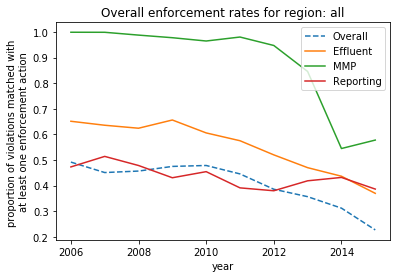

In [330]:
plot_enf_rate(merged_trim, 'all')

#### by region

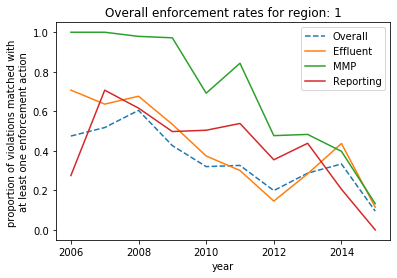

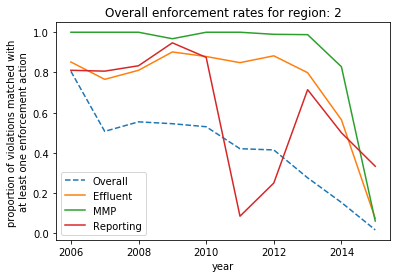

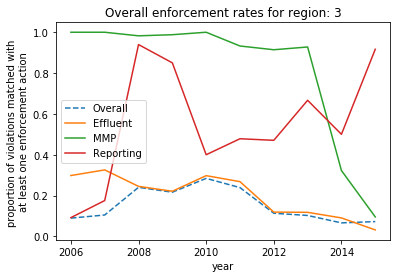

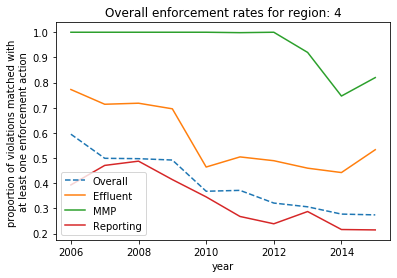

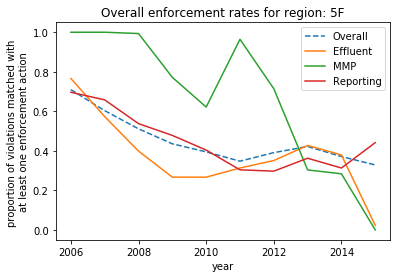

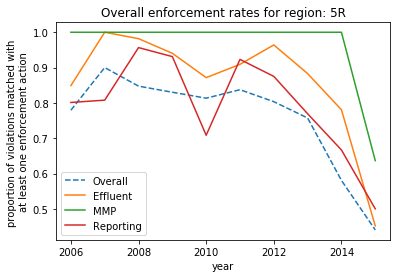

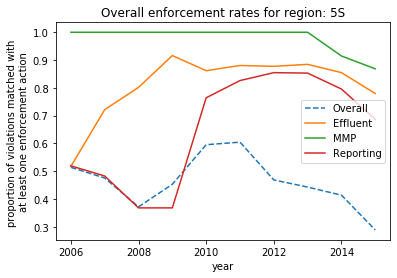

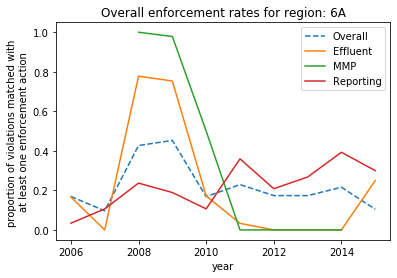

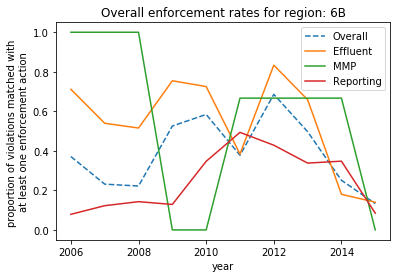

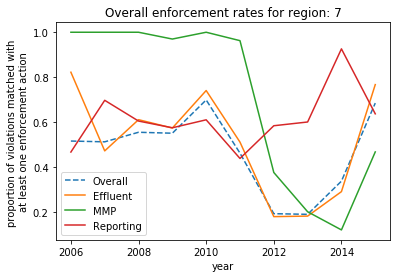

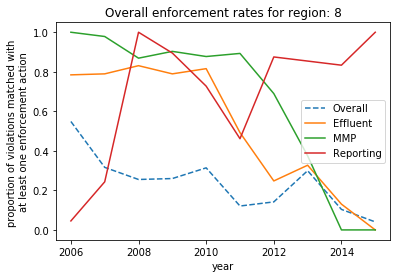

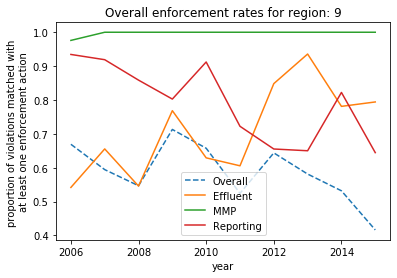

In [331]:
for r in regions: 
    plot_enf_rate(merged_trim, r)

#### for MMP violations only

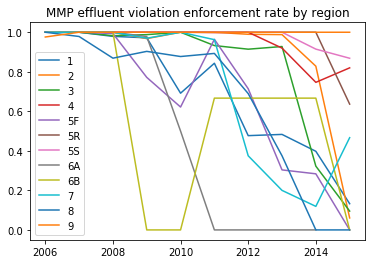

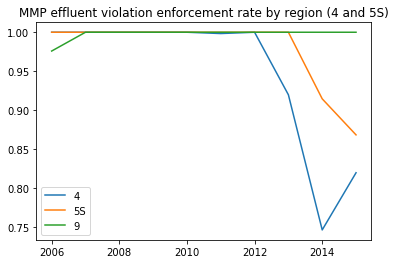

In [332]:
# rates
## all regions
plt.title('MMP effluent violation enforcement rate by region')
for r in regions: 
    plot_df = merged_trim[merged_trim['VIOLATED FACILITY REGION'] == r]
    mmp_rate = out_enf_rate(plot_df[plot_df.mmp_flag])
    plt.plot(mmp_rate)
plt.legend(regions)
plt.show()

## selected regions
plt.title('MMP effluent violation enforcement rate by region (4 and 5S)')
for r in sub_regions: 
    plot_df = merged_trim[merged_trim['VIOLATED FACILITY REGION'] == r]
    mmp_rate = out_enf_rate(plot_df[plot_df.mmp_flag])
    plt.plot(mmp_rate)
plt.legend(sub_regions)
plt.show()

## 3. Enforcement Time

In [333]:
mmp_df = merged_trim[merged_trim.mmp_flag]
grouped = mmp_df.groupby(['VIOLATED FACILITY REGION', 'violation_year', 'VIOLATION_ID', 'OCCURRED ON'])['EFFECTIVE DATE'].min().to_frame().reset_index()
enforced = grouped[~grouped['EFFECTIVE DATE'].isna()]
enforced['days_to_enf'] = (enforced['EFFECTIVE DATE'] - enforced['OCCURRED ON']).dt.days
enforced.head()

/Users/hongjinl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,VIOLATED FACILITY REGION,violation_year,VIOLATION_ID,OCCURRED ON,EFFECTIVE DATE,days_to_enf
0,1,2006.0,438406.0,2006-01-02,2009-01-29,1123
1,1,2006.0,438407.0,2006-02-28,2009-01-29,1066
2,1,2006.0,438408.0,2006-03-31,2009-01-29,1035
3,1,2006.0,438409.0,2006-02-02,2009-01-29,1092
4,1,2006.0,438410.0,2006-03-06,2009-01-29,1060


In [334]:
print(f'{len(enforced[enforced.days_to_enf < 0])/len(enforced)*100}% violation records have negative days to enforcement actions. We will remove them.')
enforced = enforced[enforced.days_to_enf >= 0]

6.4721684263134875% violation records have negative days to enforcement actions. We will remove them.


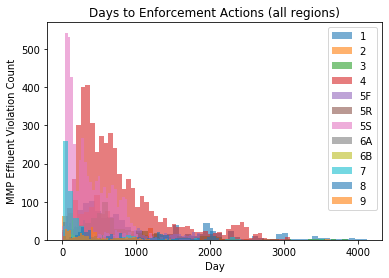

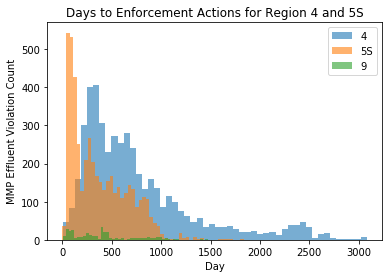

In [335]:
## all regions
plt.title('Days to Enforcement Actions (all regions)')
for r in regions: 
    region_df = enforced[enforced['VIOLATED FACILITY REGION'] == r]
    plt.hist(region_df.days_to_enf, bins = 50, alpha = 0.6)
plt.xlabel('Day')
plt.ylabel('MMP Effluent Violation Count')
plt.legend(regions)
plt.show()

## selected regions
plt.title('Days to Enforcement Actions for Region 4 and 5S')
for r in sub_regions: 
    region_df = enforced[enforced['VIOLATED FACILITY REGION'] == r]
    plt.hist(region_df.days_to_enf, bins = 50, alpha = 0.6)
plt.xlabel('Day')
plt.ylabel('MMP Effluent Violation Count')
plt.legend(sub_regions)
plt.show()

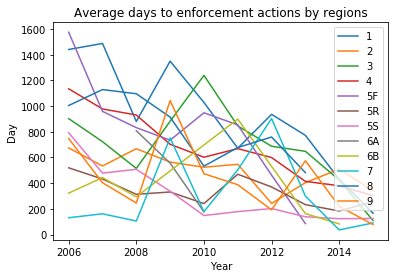

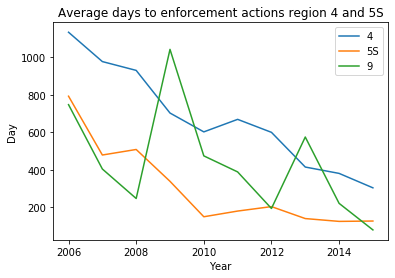

In [336]:
summary = enforced.groupby(['VIOLATED FACILITY REGION', 'violation_year'])['days_to_enf'].describe().reset_index()
## all regions
plt.title('Average days to enforcement actions by regions')
for r in regions:
    region_df = summary[summary['VIOLATED FACILITY REGION'] == r]
    plt.plot(region_df.violation_year, region_df['mean'])
plt.legend(regions)
plt.xlabel('Year')
plt.ylabel('Day')
plt.show()

## selected regions
plt.title('Average days to enforcement actions region 4 and 5S')
for r in sub_regions:
    region_df = summary[summary['VIOLATED FACILITY REGION'] == r]
    plt.plot(region_df.violation_year, region_df['mean'])
plt.legend(sub_regions)
plt.xlabel('Year')
plt.ylabel('Day')
plt.show()

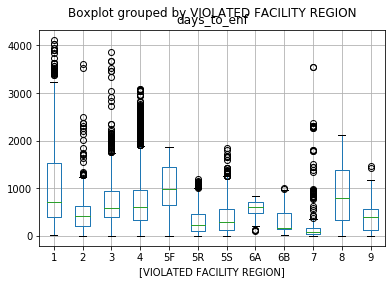

In [337]:
enforced.boxplot(by = ['VIOLATED FACILITY REGION'], column = ['days_to_enf'])
plt.show()

**Next Steps**
1. compare types of enforcement actions
2. compare enforcement rates and time across facility types
3. identify facilities with multiple enforcement actions to the same violations

**Remaining Questions** 
1. how to translate regional variations to modeling? 
2. what is the research question and methodology design? 

### 4. MMP violations 

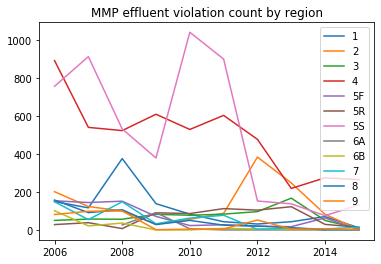

In [367]:
# counts
plt.title('MMP effluent violation count by region')
for r in regions: 
    region_df = merged_trim[merged_trim['VIOLATED FACILITY REGION'] == r]
    df = region_df[region_df.mmp_flag]
    grouped = df.groupby(['VIOLATED FACILITY REGION', 'violation_year', 'VIOLATION_ID'])['EFFECTIVE DATE'].min()
    viol_count = grouped.groupby(['violation_year']).count()
    plt.plot(viol_count)
plt.legend(regions)
plt.show()

violation_year
2006.0    0.407629
2007.0    0.378265
2008.0    0.357822
2009.0    0.241996
2010.0    0.301388
2011.0    0.294118
2012.0    0.255629
2013.0    0.229047
2014.0    0.259828
2015.0    0.329589
Name: mmp_flag, dtype: float64


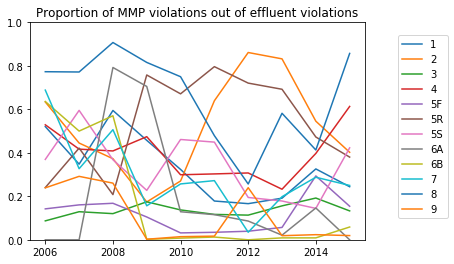

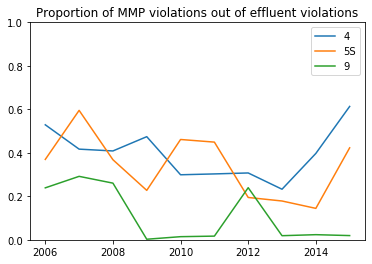

In [339]:
# proportion of effluent violations are MMP

# overall
eff_df = merged_trim[merged_trim['VIOLATION TYPE'] == 'Effluent']
print(eff_df.groupby(['violation_year'])['mmp_flag'].sum() / eff_df.groupby(['violation_year'])['mmp_flag'].count())

# all regions
plt.title('Proportion of MMP violations out of effluent violations')
for r in regions: 
    region_df = eff_df[eff_df['VIOLATED FACILITY REGION'] == r]
    mmp_rate = region_df.groupby(['violation_year'])['mmp_flag'].sum() / region_df.groupby(['violation_year'])['mmp_flag'].count()
    plt.plot(mmp_rate)
plt.ylim(0,1)
plt.legend(regions, loc=(1.1,0.1))
plt.show()

# selected regions
plt.title('Proportion of MMP violations out of effluent violations')
for r in sub_regions: 
    region_df = eff_df[eff_df['VIOLATED FACILITY REGION'] == r]
    mmp_rate = region_df.groupby(['violation_year'])['mmp_flag'].sum() / region_df.groupby(['violation_year'])['mmp_flag'].count()
    plt.plot(mmp_rate)
plt.ylim(0,1)
plt.legend(sub_regions)
plt.show()

==> there is a lot of variation in proportion of MMP violations among effluent violations.

==> overall the proportion is about 1/3 

==> Region 4 and 5S are pretty similar

### 5. Enforcement types

In [340]:
mmp_enforced = mmp_df[~mmp_df['EFFECTIVE DATE'].isna()]
mmp_enforced['penalty_assessed_flag'] = mmp_enforced['TOTAL ASSESSMENT AMOUNT'] > 0
mmp_enforced['penalty_paid_flag'] = mmp_enforced['TOTAL $ PAID/COMPLETED AMOUNT'] > 0 

# overall proportion of MMP enforcement resulting in assessed penalties
print(f'{sum(mmp_enforced.penalty_assessed_flag)/len(mmp_enforced)*100}% of MMP enforcements resulted in assessed penalties.')

61.011063554873616% of MMP enforcements resulted in assessed penalties.


/Users/hongjinl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/hongjinl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [341]:
# by region
region_dfs = []
for r in regions: 
    region_df = mmp_enforced[mmp_enforced['VIOLATED FACILITY REGION'] == r]
    mmp_enforcement_rate = out_enf_rate(mmp_df[mmp_df['VIOLATED FACILITY REGION'] == r])
    df = mmp_enforcement_rate.to_frame()
    df.columns = ['mmp_enforcement_rate']
    df['region'] = r
    df['mmp_penalty_assessed_rate'] = region_df.groupby(['violation_year'])['penalty_assessed_flag'].sum() / region_df.groupby(['violation_year'])['penalty_assessed_flag'].count()
    df['mmp_penalty_paid_rate'] = region_df[region_df.penalty_assessed_flag].groupby(['violation_year'])['penalty_paid_flag'].sum() / region_df[region_df.penalty_assessed_flag].groupby(['violation_year'])['penalty_paid_flag'].count()
    df = df.reset_index()
    region_dfs.append(df)
region_rates = pd.concat(region_dfs)
region_rates

,violation_year,mmp_enforcement_rate,region,mmp_penalty_assessed_rate,mmp_penalty_paid_rate
0,2006.0,1.000000,1,0.773585,0.845528
1,2007.0,1.000000,1,0.614754,0.786667
2,2008.0,0.979112,1,0.719603,0.348276
3,2009.0,0.971831,1,0.734104,0.590551
4,2010.0,0.691667,1,0.755814,0.523077
...,...,...,...,...,...
5,2011.0,1.000000,9,1.000000,1.000000
6,2012.0,1.000000,9,0.712329,1.000000
7,2013.0,1.000000,9,0.000000,NaN
8,2014.0,1.000000,9,0.000000,NaN


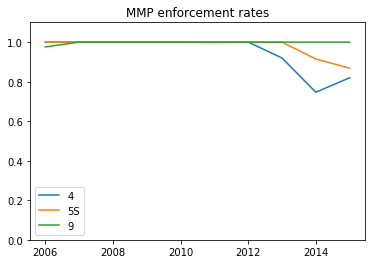

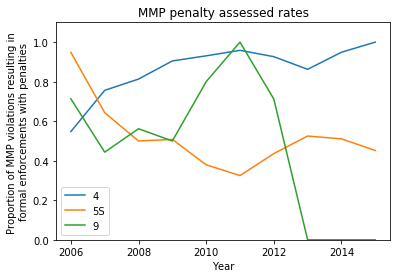

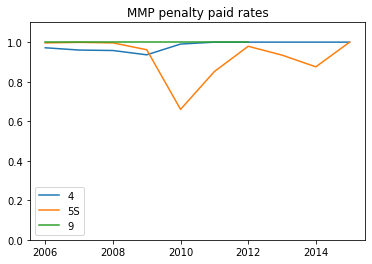

In [342]:
# enforcement rates
plt.title('MMP enforcement rates')
for r in sub_regions:
    region_df = region_rates[region_rates['region'] == r]
    plt.plot(region_df.violation_year, region_df.mmp_enforcement_rate)
plt.legend(sub_regions)
plt.ylim(0,1.1)
plt.show()

# penalty assessed rates
plt.title('MMP penalty assessed rates')
for r in sub_regions:
    region_df = region_rates[region_rates['region'] == r]
    plt.plot(region_df.violation_year, region_df.mmp_penalty_assessed_rate)
plt.legend(sub_regions)
plt.xlabel('Year')
plt.ylabel('Proportion of MMP violations resulting in \nformal enforcements with penalties')
plt.ylim(0,1.1)
plt.show()

# penalty paid rates
plt.title('MMP penalty paid rates')
for r in sub_regions:
    region_df = region_rates[region_rates['region'] == r]
    plt.plot(region_df.violation_year, region_df.mmp_penalty_paid_rate)
plt.legend(sub_regions)
plt.ylim(0,1.1)
plt.show()

### 6. Facility types 

/Users/hongjinl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Region 4: Total # of violating facilities: 6699. Waste Water Treatment Plants accounts for 20%
Region 5S: Total # of violating facilities: 9673. Waste Water Treatment Plants accounts for 89%
Region 9: Total # of violating facilities: 762. Waste Water Treatment Plants accounts for 9%


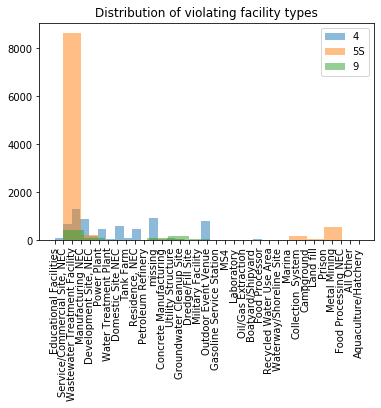

In [343]:
plt.title('Distribution of violating facility types')
for r in sub_regions:
    region_df = mmp_df[mmp_df['VIOLATED FACILITY REGION'] == r]
    region_df['PLACE SUBTYPE_x'] = region_df['PLACE SUBTYPE_x'].fillna('missing')
    print(f"Region {r}: Total # of violating facilities: {len(region_df)}. Waste Water Treatment Plants accounts for {round(sum(region_df['PLACE SUBTYPE_x'] == 'Wastewater Treatment Facility')/len(region_df)*100)}%")
    plt.hist(region_df['PLACE SUBTYPE_x'], bins = len(region_df['PLACE SUBTYPE_x'].unique()), alpha = 0.5)
plt.legend(sub_regions)    
plt.xticks(rotation = 90)
plt.show()

In [344]:
# facilities with multiple enforcement actions tied to the same violations
df = mmp_df.groupby(['VIOLATED FACILITY REGION', 'FACILITY_ID', 'PLACE SUBTYPE_x', 'VIOLATION_ID'])['EFFECTIVE DATE'].count().to_frame()
df = df.reset_index()
df[df['EFFECTIVE DATE'] > 1].sort_values('EFFECTIVE DATE', ascending = False)

,VIOLATED FACILITY REGION,FACILITY_ID,PLACE SUBTYPE_x,VIOLATION_ID,EFFECTIVE DATE
1570,2,223950.0,Petroleum Refinery,895993.0,16
1569,2,223950.0,Petroleum Refinery,895931.0,16
1573,2,223950.0,Petroleum Refinery,924443.0,8
1575,2,223950.0,Petroleum Refinery,925515.0,8
1574,2,223950.0,Petroleum Refinery,924444.0,8
...,...,...,...,...,...
9946,5S,214642.0,Wastewater Treatment Facility,914223.0,2
9945,5S,214642.0,Wastewater Treatment Facility,914222.0,2
9944,5S,214642.0,Wastewater Treatment Facility,914221.0,2
9943,5S,214642.0,Wastewater Treatment Facility,910813.0,2


In [297]:
mmp_df[mmp_df['VIOLATION_ID'] == 909277].sort_values('EFFECTIVE DATE')

,VIOLATED FACILITY REGION,FACILITY_ID,FACILITY NAME_x,AGENCY NAME_x,PLACE TYPE_x,PLACE SUBTYPE_x,PLACE LATITUDE_x,PLACE LONGITUDE_x,WDID_x,REG MEASURE ID_x,REG MEAS TYPE,VIOLATION_ID,VIOLATION TYPE,VIOLATION SUBTYPE,VIOLATION DESCRIPTION,STATUS_x,OCCURRED ON,PROGRAM_x,PROGRAM CATEGORY_x,Parameter,Limit,Result,Units,Period,Monitoring Location,Location 1_x,violation_year,ENFORCEMENT_ACTION_ID,DATE_ADDED_TO_ENFORCEMENT,xref_year,REGION,FACILITY ID,FACILITY NAME_y,AGENCY NAME_y,PLACE TYPE_y,PLACE SUBTYPE_y,PLACE LATITUDE_y,PLACE LONGITUDE_y,WDID_y,REG MEASURE ID_y,REG MEASURE TYPE,ORDER / RESOLUTION NUMBER,ENFORCEMENT ACTION TYPE,EFFECTIVE DATE,ADOPTION / ISSUANCE DATE,TERMINATION DATE,ACL ISSUANCE DATE,EPL ISSUANCE DATE,STATUS_y,TITLE,DESCRIPTION,PROGRAM_y,PROGRAM CATEGORY_y,TOTAL ASSESSMENT AMOUNT,INITIAL ASSESSED AMOUNT,LIABILITY $ AMOUNT,PROJECT $ AMOUNT,LIABILITY $ PAID,PROJECT $ COMPLETED,TOTAL $ PAID/COMPLETED AMOUNT,Location 1_y,enforcement_year,Agency,Agency Address,Facility Name,Facility Address,Latitude,Longitude,Place/Project Type,SIC/NAICS,County,Region,Program,Regulatory Measure Status,Regulatory Measure Type,Order No.,WDID,NPDES No.,Adoption Date,Effective Date,Termination Date,Expiration/Review Date,Design Flow,Major/Minor,Complexity,TTWQ,Cafo Population,# Enforcement Actions within 5 years,# Violations within 5 years,Unnamed: 27,Unnamed: 28,Unnamed: 29,record_count,duplicate_flag,npdes_flag,MMP TYPE,mmp_flag
220551,5S,214642.0,Jackson City WWTP,Jackson City,Utility,Wastewater Treatment Facility,38.34782,-120.77441,5B030103001,339946.0,NPDES Permits,909277.0,Effluent,CAT2,"Zinc, Total Monthly Average limit is 30 ug/L a...",Violation,2011-07-31,NPDMUNIOTH,NPDESWW,"Zinc, Total",30.0,100.0,ug/L,Average Monthly (AMEL),EFF-001,"(38.34782, -120.77441)",2011.0,381639.0,2011-09-29,2011.0,5S,214642.0,City of Jackson WWTP,Jackson City,Utility,Wastewater Treatment Facility,38.34782,-120.77441,5B030103001,339946.0,NPDES Permits,NaN,Notice of Violation,2011-09-21,9/21/2011,9/21/2011,NaN,NaN,Historical,NOV 09/21/2011 for Jackson City WWTP,During the monitoring period July 2011 the dis...,NPDMUNIOTH,NPDESWW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(38.34782, -120.77441)",2011.0,Jackson City,"33 Broadway, Jackson, CA 95642",City of Jackson WWTP,"39 North Highway 49-88, Jackson, CA 95642",38.34782,-120.77441,Wastewater Treatment Facility,4952,Amador,5S,NPDMUNIOTH,Active,NPDES Permit,R5-2018-0036,5B030103001,CA0079391,5/31/18,8/1/18,NaN,7/31/23,0.71,Minor,A,1.0,NaN,14.0,179.0,NaN,NaN,NaN,1.0,False,True,Serious,True
170769,5S,214642.0,Jackson City WWTP,Jackson City,Utility,Wastewater Treatment Facility,38.34782,-120.77441,5B030103001,339946.0,NPDES Permits,909277.0,Effluent,CAT2,"Zinc, Total Monthly Average limit is 30 ug/L a...",Violation,2011-07-31,NPDMUNIOTH,NPDESWW,"Zinc, Total",30.0,100.0,ug/L,Average Monthly (AMEL),EFF-001,"(38.34782, -120.77441)",2011.0,387369.0,2012-09-13,2012.0,5S,214642.0,City of Jackson WWTP,Jackson City,Utility,Wastewater Treatment Facility,38.34782,-120.77441,5B030103001,339946.0,NPDES Permits,R5-2012-0560,Admin Civil Liability,2012-09-07,9/7/2012,NaN,NaN,NaN,Active,MMPO R5-2012-0560 for Jackson City,"MMP Order issued in the amount of $411,000 for...",NPDMUNIOTH,NPDESWW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(38.34782, -120.77441)",2012.0,Jackson City,"33 Broadway, Jackson, CA 95642",City of Jackson WWTP,"39 North Highway 49-88, Jackson, CA 95642",38.34782,-120.77441,Wastewater Treatment Facility,4952,Amador,5S,NPDMUNIOTH,Active,NPDES Permit,R5-2018-0036,5B030103001,CA0079391,5/31/18,8/1/18,NaN,7/31/23,0.71,Minor,A,1.0,NaN,14.0,179.0,NaN,NaN,NaN,1.0,False,True,Serious,True


---

## Enforcement data deep dive

In [8]:
enforcements.head()

,REGION,FACILITY ID,FACILITY NAME,AGENCY NAME,PLACE TYPE,PLACE SUBTYPE,PLACE LATITUDE,PLACE LONGITUDE,WDID,REG MEASURE ID,REG MEASURE TYPE,ENFORCEMENT ID (EID),ORDER / RESOLUTION NUMBER,ENFORCEMENT ACTION TYPE,EFFECTIVE DATE,ADOPTION / ISSUANCE DATE,TERMINATION DATE,ACL ISSUANCE DATE,EPL ISSUANCE DATE,STATUS,TITLE,DESCRIPTION,PROGRAM,PROGRAM CATEGORY,TOTAL ASSESSMENT AMOUNT,INITIAL ASSESSED AMOUNT,LIABILITY $ AMOUNT,PROJECT $ AMOUNT,LIABILITY $ PAID,PROJECT $ COMPLETED,TOTAL $ PAID/COMPLETED AMOUNT,Location 1,enforcement_year
0,2,201053.0,Richmond Terminal,ConocoPhillips Company Richmond,Facility,NaN,37.913008,-122.368545,2 071198N01,161422.0,Unregulated,252031,UNKNOWN,Staff Enforcement Letter,2004-07-01,NaN,NaN,NaN,NaN,Historical,Enforcement - 2 071198N01,Letter requesting modification to monitoring p...,AGT,TANKS,0.0,0.0,0.0,0.0,0.0,0,0.0,"(37.913008, -122.368545)",2004.0
1,2,201053.0,Richmond Terminal,ConocoPhillips Company Richmond,Facility,NaN,37.913008,-122.368545,2 071198N01,161422.0,Unregulated,238143,UNKNOWN,13267 Letter,2001-08-31,NaN,NaN,NaN,NaN,Historical,Enforcement - 2 071198N01,SPCC violation submitted 13267 letter.,AGT,TANKS,0.0,0.0,0.0,0.0,0.0,0,0.0,"(37.913008, -122.368545)",2001.0
2,2,201053.0,Richmond Terminal,ConocoPhillips Company Richmond,Facility,NaN,37.913008,-122.368545,2 071198N01,161422.0,Unregulated,237843,UNKNOWN,Oral Communication,2001-11-20,NaN,11/20/2006,NaN,NaN,Historical,Enforcement - 2 071198N01,Discharger modifying bmps,AGT,TANKS,0.0,0.0,0.0,0.0,0.0,0,0.0,"(37.913008, -122.368545)",2001.0
3,2,201053.0,Richmond Terminal,ConocoPhillips Company Richmond,Facility,NaN,37.913008,-122.368545,2 071198N01,161422.0,Unregulated,236939,UNKNOWN,13267 Letter,2001-10-01,NaN,NaN,NaN,NaN,Historical,Enforcement - 2 071198N01,Notified in 13267 letter that northern portion...,AGT,TANKS,0.0,0.0,0.0,0.0,0.0,0,0.0,"(37.913008, -122.368545)",2001.0
4,2,201053.0,Richmond Terminal,ConocoPhillips Company Richmond,Facility,NaN,37.913008,-122.368545,2 071198N01,161422.0,Unregulated,236938,UNKNOWN,Oral Communication,2001-09-07,NaN,9/7/2001,NaN,NaN,Historical,Enforcement - 2 071198N01,Notified verbally during site inspection that ...,AGT,TANKS,0.0,0.0,0.0,0.0,0.0,0,0.0,"(37.913008, -122.368545)",2001.0


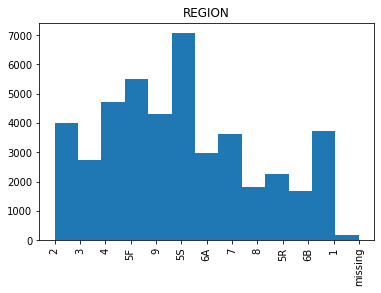

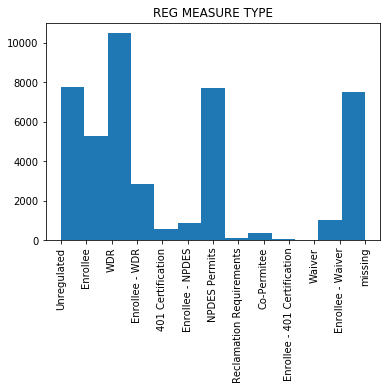

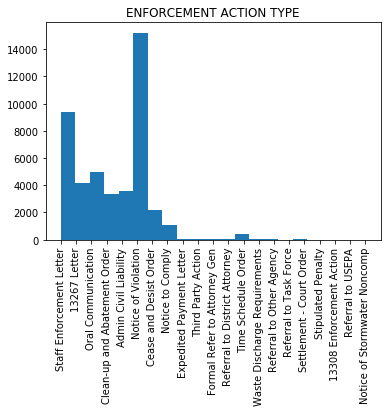

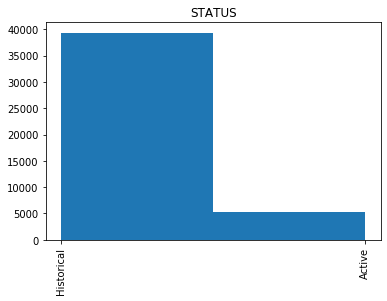

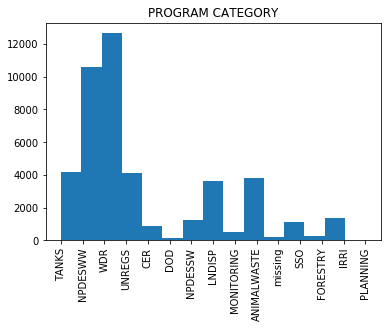

In [9]:
plot_hist(enforcements, 'REGION')
plot_hist(enforcements, 'REG MEASURE TYPE')
plot_hist(enforcements, 'ENFORCEMENT ACTION TYPE')
plot_hist(enforcements, 'STATUS')
plot_hist(enforcements, 'PROGRAM CATEGORY')

## Violations data deep dive

In [10]:
violations.head()

,VIOLATED FACILITY REGION,FACILITY_ID,FACILITY NAME,AGENCY NAME,PLACE TYPE,PLACE SUBTYPE,PLACE LATITUDE,PLACE LONGITUDE,WDID,REG MEASURE ID,REG MEAS TYPE,VIOLATION ID (VID),VIOLATION TYPE,VIOLATION SUBTYPE,VIOLATION DESCRIPTION,STATUS,OCCURRED ON,PROGRAM,PROGRAM CATEGORY,Parameter,Limit,Result,Units,Period,Monitoring Location,Location 1,violation_year
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,682567,Effluent,CAT1,"E-1 pH effluent inst. max 8.5, reported 9.04",Violation,2006-09-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006
1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,439762,Deficient Monitoring,NaN,Failed to monitor between 09/27/2006 and 09/27...,Dismissed,2006-09-27,NPDESWW,NPDESWW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006
2,6A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,505270,Order Conditions,NaN,Biological Filtration Effluent Pond 34 overfl...,Dismissed,2007-03-02,WDR,WDR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007
3,5F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,777057,Reporting,Late Report,"March 2008 SMR, due 4/1/2008, sumbitted 4/4/20...",Violation,2008-04-02,WDR,WDR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008
4,6A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,797067,Basin Plan Prohibition,NaN,Property owner has an individual waste disposa...,Violation,2007-10-22,UNREGS,UNREGS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007


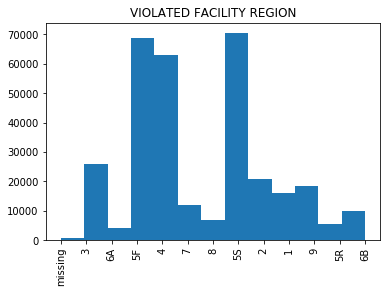

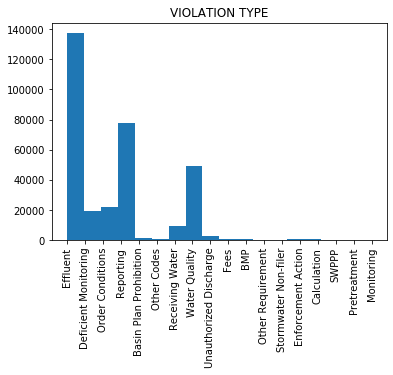

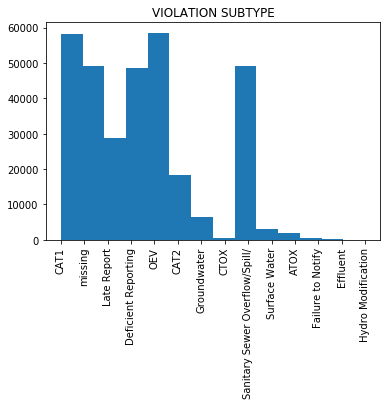

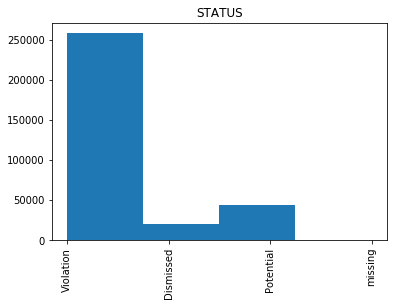

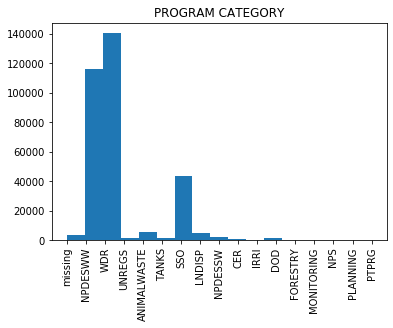

In [11]:
plot_hist(violations, 'VIOLATED FACILITY REGION')
plot_hist(violations, 'VIOLATION TYPE')
plot_hist(violations, 'VIOLATION SUBTYPE')
plot_hist(violations, 'STATUS')
plot_hist(violations, 'PROGRAM CATEGORY')